<a href="https://colab.research.google.com/github/duttagoutam/AIML/blob/master/ImageCaptioningFlickr8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning Flickr8k Dataset

In [52]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
import keras
import string
import sys, time, os, warnings 
import numpy as np
import pandas as pd
import pydotplus
from pandas import DataFrame
from array import array
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from numpy import argmax
from pickle import dump
from pickle import load
from keras.utils.vis_utils import model_to_dot
from keras.layers.pooling import GlobalMaxPooling2D
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Embedding
from keras.layers.merge import concatenate
#keras.utils.vis_utils.pydot = pydot
#from keras.backend.tensorflow_backend import set_session
#from collections import Counter 

In [0]:
folderName='/content/drive/My Drive/App/storage/Flickr8k_Dataset'
imageDir=folderName+'/Images'

## Load Photographs

In [0]:
# Not To Run Always
npix = 224
target_size = (npix,npix)

def load_photos(directory):
    images = dict()
    for name in listdir(directory):
        # load an image from file
        #print("name",name)
        filename = directory + '/' + name
        image = load_img(filename, target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get image id
        image_id = name.split('.')[0]
        images[image_id] = image
    return images

In [5]:
# Not To Run Always
# load images
#directory = 'Flicker8k_Dataset'
directory = imageDir
images = load_photos(directory)
print('Loaded Images: %d' % len(images))

KeyboardInterrupt: ignored

## Extract Features

In [0]:
# Not To Run Always
# extract features from each photo in the directory
def extract_features(directory):    
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    features = dict()
    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
        #print('>%s' % name)
    return features

In [7]:
# Not To Run Always
# extract features from all images
#directory = 'Flickr8k_Dataset'
directory = imageDir
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open(folderName+'/features.pkl', 'wb'))
print('Image Features: %d' % len(features))





553467904/553467096 [==============================] - 6s 0us/step


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________

KeyboardInterrupt: ignored

## Prepare Text Data

In [0]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [0]:
# Not To Run Always
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

In [0]:
# Not To Run Always
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [0]:
# Not To Run Always
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [0]:
# Not To Run Always
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [9]:
# Not To Run Always
filename = folderName+'/Flickr_TextData/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, folderName+'/descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


# Loading Data

In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [0]:
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [0]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [0]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [0]:
# calculate the length of the description with the most words
def maximum_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [0]:
# Not Working
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    #X1, X2, y = [], [], []
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
        #X1 = np.array(X1)
        #X2 = np.array(X2)
        #y  = np.array(y)
    
    return np.array(X1), np.array(X2), np.array(y)
    #return (X1, X2, y)

In [0]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)

In [0]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield [[in_img, in_seq], out_word]

## Train Dataset

In [0]:
# Not Working
# load training dataset (6K)
#filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
filename = folderName+'/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features(folderName+'/features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


## Test dataset

In [1]:
# Not Working
# load test set
#filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
filename = folderName+'/Flickr_TextData/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features(folderName+'/features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

NameError: ignored

## Fit The Model

In [0]:
# Not Working
# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
filepath = folderName+'/'+'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=10, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))
print('Model Fitting Done Successfully')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [0]:
# load training dataset (6K)
filename = folderName+'/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features(folderName+'/features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)
 
# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	# fit for one epoch
	model.fit_generator(generator, epochs=i, steps_per_epoch=steps, verbose=1)
	# save model
  #filepath = folderName+'/'+'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
	model.save(folderName+'/'+'model_' + str(i) + '.h5')

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_3[0][0]          

## Evaluate Model

In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [0]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [0]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))        

In [69]:
# prepare tokenizer on train set
 
# load training dataset (6K)
filename = folderName+'/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34


In [70]:
# prepare test set
 
# load test set
filename = folderName+'/Flickr_TextData/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features(folderName+'/features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [41]:
# load the model
#filename = folderName+'/'+'model-ep001-loss4.523-val_loss4.065.h5'
filename = folderName+'/model_7.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.527713
BLEU-2: 0.277879
BLEU-3: 0.186908
BLEU-4: 0.085236


# Generate New Captions

In [71]:
# Not run Always
# load training dataset (6K)
filename = folderName+'/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open(folderName+'/tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [0]:
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

In [75]:
# load the tokenizer
tokenizer = load(open(folderName+'/tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
filename = folderName+'/model_7.h5'
model = load_model(filename)
# load and prepare the photograph
imageFileName = imageDir+'/10815824_2997e03d76.jpg'
photo = extract_features(imageFileName)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq man in black shirt is walking on the street endseq


#  Fit Dev Images

In [0]:
# split a dataset into train/test elements
def train_test_split(dataset):
	# order keys so the split is consistent
	ordered = sorted(dataset)
	# return split dataset as two new sets
	return set(ordered[:100]), set(ordered[100:200])

In [77]:
# load dev set
filename = folderName+'/Flickr_TextData/Flickr_8k.devImages.txt'
dataset = load_set(filename)
print('Dataset: %d' % len(dataset))
# train-test split
train, test = train_test_split(dataset)
print('Train=%d, Test=%d' % (len(train), len(test)))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', train)
test_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', test)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions), len(test_descriptions)))
# photo features
train_features = load_photo_features(folderName+'/features.pkl', train)
test_features = load_photo_features(folderName+'/features.pkl', test)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 1000
Train=100, Test=100
Descriptions: train=100, test=100
Photos: train=100, test=100
Vocabulary Size: 876
Description Length: 31


In [0]:
# evaluate the skill of the model
def evaluate_model_new(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		actual.append([d.split() for d in desc])
		predicted.append(yhat.split())
	print('Actual:    %s' % desc)
	print('Predicted: %s' % yhat)
	# calculate BLEU score
	bleu = corpus_bleu(actual, predicted)
	return bleu

In [0]:
# define experiment
def run_experiment(model_name, func_name, verbose, n_epochs, n_photos_per_update, n_batches_per_epoch, n_repeats):
  # run experiment
  train_results, test_results = list(), list()
  for i in range(n_repeats):
    # define the model
    model = func_name(vocab_size, max_length)
    # fit model
    #data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model_new(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model_new(model, test_descriptions, test_features, tokenizer, max_length)
    print("train_score:", train_score)
    print("test_score:", test_score)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    #print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
  # save results to file
  resultFolder = folderName+'/Result'
  df = DataFrame()
  df['train'] = train_results
  df['test'] = test_results
  print(df.describe())
  df.to_csv(resultFolder+'/'+model_name+'.csv', index=False)

In [82]:
# define experiment
model_name = 'baseline1'
verbose = 1
n_epochs = 10
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 1
#func = define_model(vocab_size, max_length)
run_experiment(model_name, define_model, verbose, n_epochs, n_photos_per_update, n_batches_per_epoch, n_repeats)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 31)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 31, 256)      224256      input_21[0][0]                   
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 4096)         0           input_20[0][0]                   
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Actual:    ['startseq man in an orange construction uniform wears white hardhat and sprays water hose endseq', 'startseq man in an orange safety suit spraying water endseq', 'startseq man in public road workers uniform sprays water endseq', 'startseq man wearing an orange uniform is working outside with hose endseq', 'startseq the man in the work uniform is using water hose endseq']
Predicted: startseq girl girl people people endseq
train_score: 0.12188045378562154
test_score: 0.09634775668507153
         train      test
count  1.00000  1.000000
mean   0.12188  0.096348
std        NaN       NaN
min    0.12188  0.096348
25%    0.12188  0.096348
50%    0.12188  0.096348
75%    0.12188  0.096348
max    0.12188  0.096348


In [83]:
# Generate Baseline model
model_name = 'baseline_generate'
n_repeats = 1
run_experiment(model_name, define_model, verbose, n_epochs, n_photos_per_update, n_batches_per_epoch, n_repeats)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 31)           0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 31, 256)      224256      input_23[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 4096)         0           input_22[0][0]                   
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Actual:    ['startseq man in an orange construction uniform wears white hardhat and sprays water hose endseq', 'startseq man in an orange safety suit spraying water endseq', 'startseq man in public road workers uniform sprays water endseq', 'startseq man wearing an orange uniform is working outside with hose endseq', 'startseq the man in the work uniform is using water hose endseq']
Predicted: startseq man man with with window endseq
train_score: 0.04988715715577709
test_score: 0.05803093609932879
          train      test
count  1.000000  1.000000
mean   0.049887  0.058031
std         NaN       NaN
min    0.049887  0.058031
25%    0.049887  0.058031
50%    0.049887  0.058031
75%    0.049887  0.058031
max    0.049887  0.058031


In [0]:
# define the captioning model
def size_sm_fixed_vec(vocab_size, max_length):
	# feature extractor (encoder)
	inputs1 = Input(shape=(7, 7, 512))
	fe1 = GlobalMaxPooling2D()(inputs1)
	fe2 = Dense(64, activation='relu')(fe1)
	fe3 = RepeatVector(max_length)(fe2)
	# embedding
	inputs2 = Input(shape=(max_length,))
	emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
	emb3 = LSTM(256, return_sequences=True)(emb2)
	emb4 = TimeDistributed(Dense(64, activation='relu'))(emb3)
	# merge inputs
	merged = concatenate([fe3, emb4])
	# language model (decoder)
	lm2 = LSTM(500)(merged)
	lm3 = Dense(500, activation='relu')(lm2)
  
	outputs = Dense(vocab_size, activation='softmax')(lm3)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [93]:
# Generate Baseline model
model_name = 'size_sm_fixed_vec'
verbose = 1
n_epochs = 10
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 1
run_experiment(model_name, size_sm_fixed_vec, verbose, n_epochs, n_photos_per_update, n_batches_per_epoch, n_repeats)

Epoch 1/10


ValueError: ignored

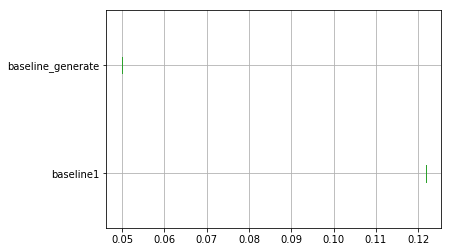

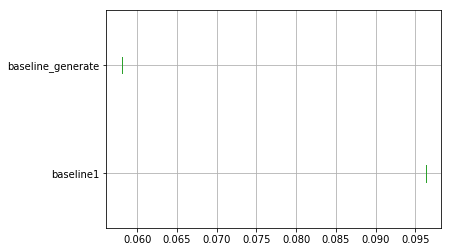

In [95]:
from pandas import read_csv
from matplotlib import pyplot
 
# load all .csv results into a dataframe
train, test = DataFrame(), DataFrame()
#directory = 'results'
directory =  folderName+'/Result'
for name in listdir(directory):
	if not name.endswith('csv'):
		continue
	filename = directory + '/' + name
	data = read_csv(filename, header=0)
	experiment = name.split('.')[0]
	train[experiment] = data['train']
	test[experiment] = data['test']
 
# plot results on train
train.boxplot(vert=False)
pyplot.show()
# plot results on test
test.boxplot(vert=False)
pyplot.show()